<a href="https://colab.research.google.com/github/Elias-VA/Practica_Python/blob/main/Neuronal_Celular_Aut%C3%B3mata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Biblioteca"""
import PIL
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D
import tensorflow as tf
import cv2
from IPython.display import clear_output
from PIL import Image
import time

Introduzca la direccion de la imagen a replicar:/content/drive/MyDrive/Poyecto_tesis_Licenciatura/Imagenes_replicar/Primer_tomo/Replicar_Celular_Automata/Slide_156.png
Introduzca la dimensión de la imagen100
Estas son las dimensiones de la imagen entrante  (100, 100, 4)


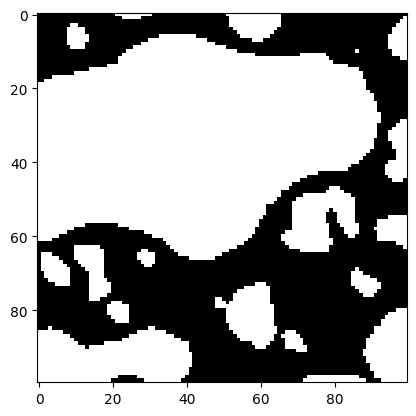

Dimensiones de la imagen que se trabajará  (100, 100, 3)
Maximo y minimo de la imagen 1.0 0.0


In [2]:

TARGET_IMAGE = input('Introduzca la direccion de la imagen a replicar:')
TARGET_SIZE = int(input('Introduzca la dimensión de la imagen'))

def load_image(TARGET_IMAGE, TARGET_SIZE):
    img = Image.open(TARGET_IMAGE)
    img.thumbnail((TARGET_SIZE, TARGET_SIZE), Image.LANCZOS)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]

    return img


target = load_image(TARGET_IMAGE, TARGET_SIZE)

print('Estas son las dimensiones de la imagen entrante ', target.shape)

def to_rgb(x):
    # asumir que el rgb está premultiplicado por alfa
    rgb, a = x[..., :3], x[..., 3:4]
    return 1.0 - a + rgb

plt.imshow(to_rgb(target))
plt.show()
print('Dimensiones de la imagen que se trabajará ', to_rgb(target).shape)
print('Maximo y minimo de la imagen', np.max(to_rgb(target)), np.min(to_rgb(target)))

In [3]:
"""Generar modelo automata"""
CHN = 16

seed = np.zeros([1, TARGET_SIZE, TARGET_SIZE, CHN], np.float32)
seed[:, TARGET_SIZE//2, TARGET_SIZE//2, 3:] = 1.0

class CAModel(tf.keras.Model):
    def __init__(self, CHN):
        super(CAModel, self).__init__()
        self.model = tf.keras.Sequential([
            Conv2D(128, 5, padding='same', activation=tf.nn.relu, input_shape=(TARGET_SIZE, TARGET_SIZE, CHN)),
            Conv2D(64, 5, padding='same', activation=tf.nn.relu),
            Conv2D(CHN, 1, padding='same', kernel_initializer=tf.zeros_initializer)
        ])

    @tf.function
    def call(self, x):
        return x + self.model(x)

# Crear una instancia del modelo
camodel = CAModel(CHN)

# Ver el resumen del modelo
camodel.model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 128)       │          51,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 16)        │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,232 (1004.81 KB)

 Trainable params: 257,232 (1004.81 KB)

 Non-trainable params: 0 (0.00 B)

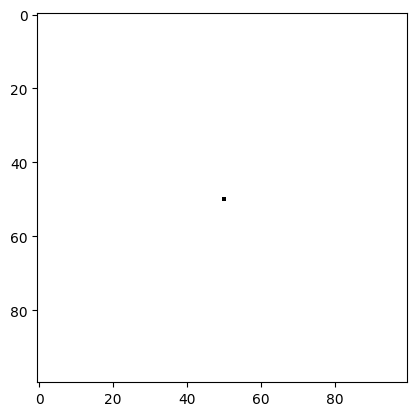

In [4]:
ca = CAModel(CHN)
x = seed
for i in range(100):
  x= ca(x)
plt.imshow(to_rgb(x[0]))
plt.show()




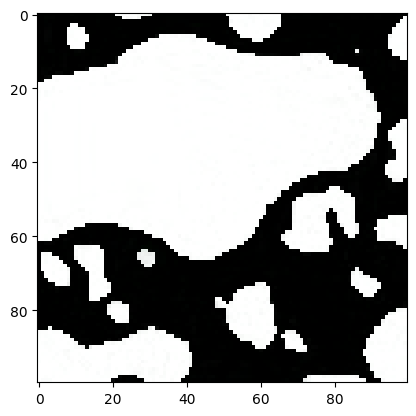

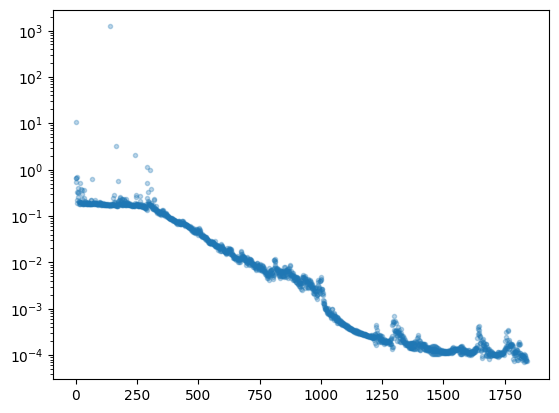

Iteration: 1840, Loss: 7.356690184678882e-05, Time per iteration: 0.0914 seconds
Loss reached 4.7372108383569866e-05 at iteration 1845
Total training time: 261.58 seconds


In [5]:
# Definir el optimizador
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [1e-3, 3e-4])
trainer = tf.optimizers.Adam(learning_rate=lr)

# Función de entrenamiento
@tf.function
def train_step(seed, target, ca, trainer):
    with tf.GradientTape() as g:
        x = seed
        for i in range(100):
            x = ca(x)
        loss = tf.reduce_mean(tf.square(x[..., :4] - target))
    params = ca.trainable_variables
    grads = g.gradient(loss, params)
    grads = [g / (tf.norm(g) + 1e-8) for g in grads]  # Regularización de gradientes
    trainer.apply_gradients(zip(grads, params))
    return loss, x

# Entrenamiento
start_time = time.time()
loss_log = []

for i in range(10000):
    iter_start_time = time.time()
    loss, x = train_step(seed, target, ca, trainer)
    iter_end_time = time.time()
    iter_duration = iter_end_time - iter_start_time

    loss_log.append((loss.numpy(), iter_duration))

    if i % 20 == 0:
        clear_output(True)
        plt.imshow(to_rgb(x[0]))
        plt.show()
        plt.plot([log[0] for log in loss_log], '.', alpha=0.3)
        plt.yscale('log')
        plt.show()
        print(f"Iteration: {i}, Loss: {loss.numpy()}, Time per iteration: {iter_duration:.4f} seconds", flush=True)

    if loss.numpy() < 0.00006:
        print(f"Loss reached {loss.numpy()} at iteration {i}")
        break

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

In [ ]:
"""renombramiento de las imagenes """
imagen_original = np.array(to_rgb(target))
imagen_replicada = to_rgb(x[0])
imagen_replicada = np.array(imagen_replicada)




# Forzar los valores a estar en el rango [-1, 1]
imagen_replicada = np.clip(imagen_replicada, 0, 1)

#Imprimir la imagen_replicada
print('Esta es la matri de la imagen replicada', imagen_replicada)






#Convertir a escalas a grises
imagen_original = cv2.cvtColor(imagen_original, cv2.COLOR_RGB2GRAY)
imagen_replicada = cv2.cvtColor(imagen_replicada, cv2.COLOR_RGB2GRAY)






"""Visualización de imagenes"""
# Visualización de las dos imágenes (fuente y creada)
plt.subplot(1, 2, 1)
plt.imshow(imagen_original, cmap='gray')
plt.title('Imagen original')

plt.subplot(1, 2, 2)
plt.imshow(imagen_replicada, cmap='gray')
plt.title('Imagen replicada')

plt.show()



In [ ]:
"""Imagen diferencia"""

#Diferencia entre las imagenes
imagen_diferencia =np.abs(imagen_original - imagen_replicada)

#Confirmación de matriz Numpy de  imagen diferencia}
imagen_diferencia = np.array(imagen_diferencia)


# Obtener los valores mínimos y máximos de la imagen de diferencia
minvalor = np.min(imagen_diferencia)
maxvalor = np.max(imagen_diferencia)
print(f"Valor mínimo de la imagen diferencia: {minvalor}")
print(f"Valor máximo de la imagen diferenica: {maxvalor}")


"""Visualización de la imagen diferencia"""
plt.figure()
plt.title('Imagen de Diferencia')
plt.imshow(imagen_diferencia,cmap='Spectral')

plt.colorbar()

plt.show()

print(np.min(imagen_replicada))
print(np.max(imagen_replicada))




In [ ]:
"""Calculo de la porosidad"""

#Porosidad imagen original
phi_original = np.sum(imagen_original ==1) / (np.sum(imagen_original == 0) + np.sum(imagen_original == 1))
print(f'La porosidad total de la imagen original es {phi_original}')
print(f"La porosidad total en porcentaje de la imagen original es {phi_original*100}% \n")


#Porosidad imagen replicada
phi_replicada = np.sum(imagen_replicada > 0.99) / (np.sum(imagen_original == 0 ) + np.sum(imagen_original == 1))
print(f'La porosidad total de la imagen replicada es {phi_replicada}')
print(f"La porosidad total en porcentaje de la imagen replicada es {phi_replicada*100}% \n")




"""Calculo de errores de imagenes"""
#Error absoluto medio (Promedio de las diferencias)
diferencia_absoluta = np.abs(imagen_original - imagen_replicada)
suma_diferencias = np.sum(diferencia_absoluta)

total_pixeles= np.sum(imagen_original > 0.99) + np.sum(imagen_original == 1)
promedio_diferencia = suma_diferencias / total_pixeles
print(f"El promedio de las diferencias es : {promedio_diferencia}", "\n")

#Error relativo
error_relativo = (np.abs(np.sum(imagen_original) - np.sum(imagen_replicada))) / np.sum(imagen_original)
error_relativo_porcentaje = error_relativo * 100
print(f'El error relativo de la imagen creada es {error_relativo}')
print(f'El error relativo en porcentaje de la imagen creada es {error_relativo_porcentaje}% \n')


"""Calculo de errores de la porosidad"""

#Diferencia de porosidades
error_absoluto_phi = np.abs(phi_original - phi_replicada)
print(f'El la diferencia entre las porosidades es {error_absoluto_phi} \n')

#Error relativo
error_relativo_phi = error_absoluto_phi / phi_original
print(f'El error relativo de la porosidad es {error_relativo_phi}')

In [ ]:


"""Guardar imagen"""
"""Guardar imagen replicada"""

# Redimensionar la imagen creada a valores entre 0 y 255
imagen_replicada *= 255
imagen_replicada = imagen_replicada.astype(np.uint8)

# Guardar la imagen creada en el disco
output_image = input('Introduzca el nombre que desee que tenga la imagen replicada')
cv2.imwrite(f'/content/drive/MyDrive/Poyecto_tesis_Licenciatura/Imagenes_replicadas_Tesis/Replicada con automata/{output_image}.png', imagen_replicada)

print("La imagen creada ha sido guardada correctamente \n")

Introduzca el nombre que desee que tenga la imagen replicadaSlide_1901
La imagen creada ha sido guardada correctamente 

